# Correlation Analysis: Targets vs Features

Use this notebook to:
- Inspect correlations among 4 target variables
- Inspect correlations between those 4 targets and 20 other numeric variables
- Visualize results with heatmaps and per-target top-20 bar charts

Instructions:
- Set your target column names in the `target_variables` list below. If you leave it empty, the notebook will attempt to auto-select 4 numeric columns.
- Adjust the data path if needed.
- Choose `pearson` or `spearman` in `correlation_method`.

Figures will also be saved under `html/` for easy sharing.


In [1]:
# --- Setup & Configuration ---
import os
import math
import json
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', 200)
plt.style.use('seaborn-v0_8')
sns.set_context('notebook', font_scale=1.1)

# --- User configuration ---
# Common dataset filenames in this project
data_filenames = [
    "dynamic_supply_chain_logistics_dataset.csv",
    "dynamic_supply_chain_with_modes.csv",
    "dynamic_supply_chain_with_modes_expanded.csv",
]

# Path candidates (relative); additional discovery happens in the data loading cell
data_path_candidates = [
    # current dir
    *(f"{name}" for name in data_filenames),
    # typical subfolders from project root
    *(f"datasets/{name}" for name in data_filenames),
    *(f"notebooks/jupyter/{name}" for name in data_filenames),
    # typical from notebook cwd
    *(f"../datasets/{name}" for name in data_filenames),
    *(f"../../datasets/{name}" for name in data_filenames),
]

# Explicit 4 target variables
# A) disruption_likelihood_score (0-1)
# B) delay_probability (0-1)
# C) risk_classification (categorical {Low Risk, Moderate Risk, High Risk})
# D) delivery_time_deviation (hours)
target_variables: List[str] = [
    "disruption_likelihood_score",
    "delay_probability",
    "risk_classification",
    "delivery_time_deviation",
]

# Correlation method: 'pearson' (linear) or 'spearman' (rank-based)
correlation_method: str = 'spearman'

# Output directory for figures
output_dir = 'html'
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded.")


Configuration loaded.


In [2]:
# --- Data Loading Helpers ---
def first_existing_path(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None


def recursive_find(start_dir: str, filenames: List[str], max_depth: int = 4) -> str | None:
    start_dir = os.path.abspath(start_dir)
    for depth in range(max_depth + 1):
        # Walk current level
        for root, dirs, files in os.walk(start_dir):
            for name in filenames:
                if name in files:
                    return os.path.join(root, name)
        # Move one level up for the next iteration
        parent = os.path.dirname(start_dir)
        if parent == start_dir:
            break
        start_dir = parent
    return None


csv_path = first_existing_path(data_path_candidates)
if csv_path is None:
    # Try a recursive search from the notebook's directory upwards
    csv_path = recursive_find(start_dir=".", filenames=data_filenames, max_depth=5)

if csv_path is None:
    raise FileNotFoundError("Could not find dataset. Update `data_path_candidates` or set an absolute path.")

print(f"Reading CSV from: {csv_path}")
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


Reading CSV from: dynamic_supply_chain_logistics_dataset.csv
(32065, 26)


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,0.742735,3.818972,2530.431941,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,0.431088,14.001491,2146.190197,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [3]:
# --- Target & Feature Selection & Encoding ---
# Encode risk_classification to ordered numeric for correlation
# Mapping: Low Risk -> 0, Moderate Risk -> 1, High Risk -> 2
risk_map = {
    'low risk': 0,
    'moderate risk': 1,
    'high risk': 2,
}

df_corr = df.copy()
if 'risk_classification' in df_corr.columns:
    df_corr['risk_classification'] = (
        df_corr['risk_classification']
        .astype(str)
        .str.strip()
        .str.lower()
        .map(risk_map)
    )

# Validate targets
missing = [c for c in target_variables if c not in df_corr.columns]
if missing:
    raise ValueError(f"Target columns not found in data: {missing}")
if len(target_variables) != 4:
    raise ValueError("Please specify exactly 4 target variables.")

# Infer numeric columns after encoding
numeric_cols_corr = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Choose candidate features: all numeric, excluding the targets
feature_candidates = [c for c in numeric_cols_corr if c not in target_variables]
if not feature_candidates:
    raise ValueError("No numeric feature candidates available after excluding targets.")

# Use all remaining numeric features
selected_features = feature_candidates

print("Targets:", target_variables)
print("Numeric features available (excluding targets):", len(selected_features))


Targets: ['disruption_likelihood_score', 'delay_probability', 'risk_classification', 'delivery_time_deviation']
Numeric features available (excluding targets): 21


In [10]:
# --- Correlation Utilities ---
def compute_correlation(df_in: pd.DataFrame, cols_x: List[str], cols_y: List[str], method: str = 'pearson') -> pd.DataFrame:
    sub = df_in[cols_x + cols_y].copy()
    corr = sub[cols_x + cols_y].corr(method=method)
    # Extract block rows X vs columns Y
    return corr.loc[cols_x, cols_y]


def plot_heatmap_targets(
    matrix: pd.DataFrame,
    title: str,
    figsize=(7, 6),
    cmap='vlag',
    annot=True,
    fmt='.2f',
    save_path: str | None = None,
):
    data = matrix.copy()
    mask = np.triu(np.ones_like(data, dtype=bool)) if data.shape[0] == data.shape[1] else None
    # Turn off annot if tiny cells (but for 4x4 we keep it on)
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        data,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        cbar=True,
        linewidths=0,
        mask=mask,
        cbar_kws={"shrink": 0.8, "label": "Correlation"},
    )
    ax.set_title(title, pad=10, fontsize=13, fontweight='bold')
    ax.tick_params(labelsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        try:
            base, _ = os.path.splitext(save_path)
            plt.savefig(base + '.svg', bbox_inches='tight')
        except Exception:
            pass
    plt.show()


def plot_heatmap_clustered(
    matrix: pd.DataFrame,
    title: str,
    figsize=(12, 8),
    cmap='vlag',
    save_path: str | None = None,
):
    # Cluster features and/or targets to group similar correlation patterns
    g = sns.clustermap(
        matrix,
        cmap=cmap,
        center=0,
        vmin=-1,
        vmax=1,
        method='average',
        metric='euclidean',
        figsize=figsize,
        cbar_kws={"label": "Correlation"},
        dendrogram_ratio=(0.12, 0.10),
        colors_ratio=0.02,
        linewidths=0,
        xticklabels=True,
        yticklabels=True,
    )
    plt.subplots_adjust(top=0.92)
    g.fig.suptitle(title, fontsize=13, fontweight='bold')
    if save_path:
        g.savefig(save_path, dpi=200, bbox_inches='tight')
        try:
            base, _ = os.path.splitext(save_path)
            g.savefig(base + '.svg', bbox_inches='tight')
        except Exception:
            pass
    plt.show()


def plot_top_k_bars_simple(
    series: pd.Series,
    k: int,
    title: str,
    figsize=(8, 6),
    save_path: str | None = None,
):
    top = series.reindex(series.abs().sort_values(ascending=False).index)[:k]
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=top.values, y=top.index, orient='h', color=sns.color_palette('deep')[0])
    plt.axvline(0, color='0.35', linewidth=1, linestyle='--')
    ax.set_title(title, pad=10, fontsize=13, fontweight='bold')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Feature')
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        try:
            base, _ = os.path.splitext(save_path)
            plt.savefig(base + '.svg', bbox_inches='tight')
        except Exception:
            pass
    plt.show()

print("Helpers ready.")


Helpers ready.


In [28]:
# --- 1) Correlation among target variables ---
# Compute correlation matrix among the 4 targets on encoded df
corr_targets = df_corr[target_variables].corr(method=correlation_method)

print("Correlation among targets:")
corr_targets



Correlation among targets:


,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
disruption_likelihood_score,1.000000,-0.005807,0.760845,0.003329
delay_probability,-0.005807,1.000000,-0.005663,0.006651
risk_classification,0.760845,-0.005663,1.000000,0.003311
delivery_time_deviation,0.003329,0.006651,0.003311,1.000000


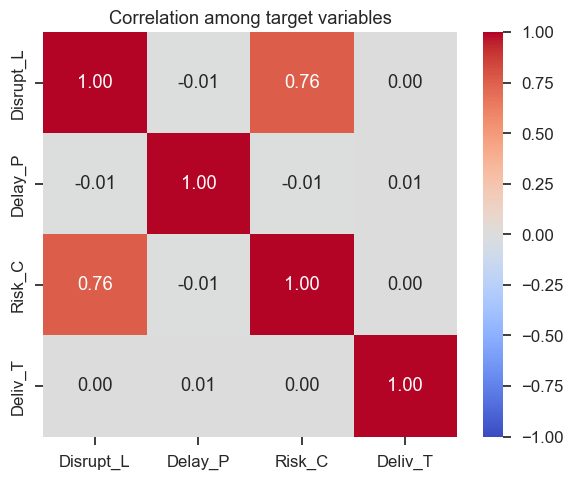

In [40]:
# Mapping long variable names to shorter ones
short_labels = {
    "disruption_likelihood_score": "Disrupt_L",
    "delay_probability": "Delay_P",
    "risk_classification": "Risk_C",
    "delivery_time_deviation": "Deliv_T"
}

# Apply renaming
corr_targets_short = corr_targets.rename(index=short_labels, columns=short_labels)

# Plot with shorter labels
plot_heatmap_targets(
    corr_targets_short,
    title="Correlation among target variables",
    figsize=(6,5)
)




In [41]:
# --- 2) Correlation: targets vs selected features ---
# Compute target vs feature correlations (4 x N features) using encoded df
corr_t_vs_f = compute_correlation(df_corr, target_variables, selected_features, method=correlation_method)

print("Correlation: targets vs selected features:")
corr_t_vs_f


Correlation: targets vs selected features:


,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score
disruption_likelihood_score,-0.006236,0.000007,-0.001108,0.009912,-0.001919,-0.011219,0.001269,-0.000759,-0.006280,-0.005422,0.006885,-0.002588,-0.001159,-0.002449,0.003205,-0.007131,0.003916,0.000468,-0.001540,0.003666,0.002671
delay_probability,-0.005350,-0.007071,-0.013845,-0.011872,-0.003622,0.006380,-0.000199,0.000404,0.007663,0.001217,0.006684,-0.002559,-0.000477,-0.000417,-0.005674,0.000946,0.000578,-0.006897,0.002380,-0.004113,0.005217
risk_classification,-0.003843,0.002159,0.002450,0.003025,-0.000606,-0.008631,0.000070,0.006367,-0.007340,-0.000029,0.004427,-0.004015,0.002599,0.005153,0.001426,-0.006861,0.008167,0.002324,0.002904,0.003623,0.004193
delivery_time_deviation,0.001411,-0.002442,0.010885,0.005704,-0.003208,-0.006160,0.003997,-0.001949,0.005266,0.000377,0.011832,0.000242,0.004712,-0.003188,-0.000047,0.001690,-0.004517,-0.000972,-0.006321,-0.003464,-0.000053


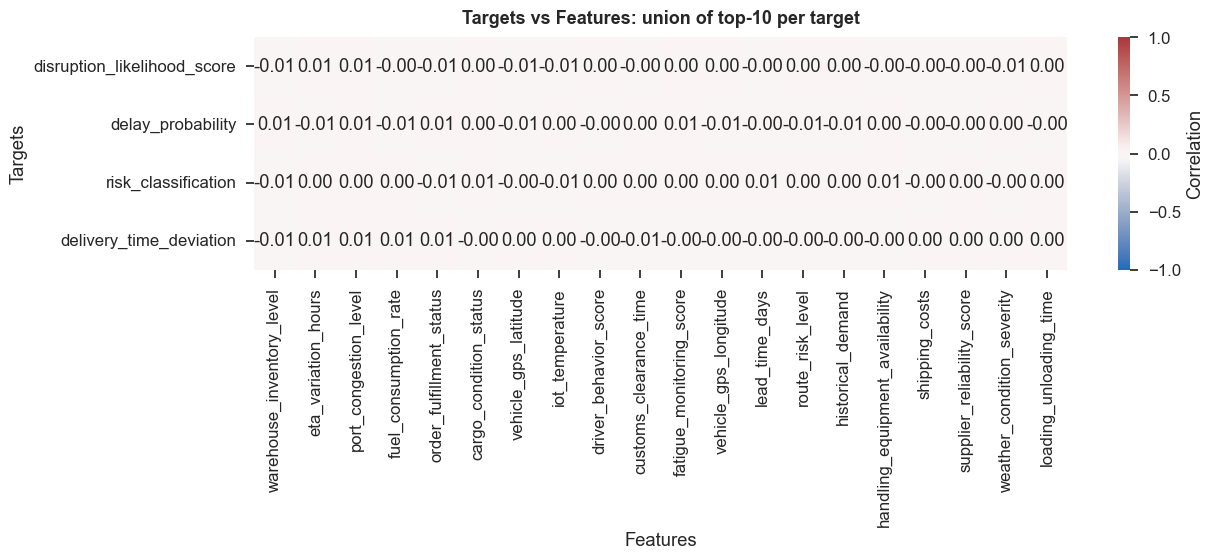

In [44]:
# Heatmap: targets vs features (compact: union of top-10 per target)
# Build a readable heatmap by selecting, for each target, its top-10 absolute correlations
k = 10
selected_cols = []
for target in target_variables:
    topk = corr_t_vs_f.loc[target].abs().sort_values(ascending=False).head(k).index.tolist()
    selected_cols.extend(topk)
# Unique while preserving order
seen = set()
selected_cols_unique = [c for c in selected_cols if not (c in seen or seen.add(c))]
# Subset and order columns by mean absolute correlation across targets
sub = corr_t_vs_f.loc[target_variables, selected_cols_unique]
col_order = sub.abs().mean(axis=0).sort_values(ascending=False).index.tolist()
sub = sub[col_order]

plt.figure(figsize=(max(10, 0.45 * len(col_order) + 4), 3 + 0.7 * len(target_variables)))
ax = sns.heatmap(
    sub,
    cmap='vlag',
    center=0,
    vmin=-1,
    vmax=1,
    annot=len(col_order) <= 30,
    fmt='.2f',
    cbar_kws={"label": "Correlation"},
    linewidths=0,
)
ax.set_title(f"Targets vs Features: union of top-{k} per target", fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel("Features")
ax.set_ylabel("Targets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"targets_vs_features_{correlation_method}.png"), dpi=200, bbox_inches='tight')
try:
    base, _ = os.path.splitext(os.path.join(output_dir, f"targets_vs_features_{correlation_method}.png"))
    plt.savefig(base + '.svg', bbox_inches='tight')
except Exception:
    pass
plt.show()


C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


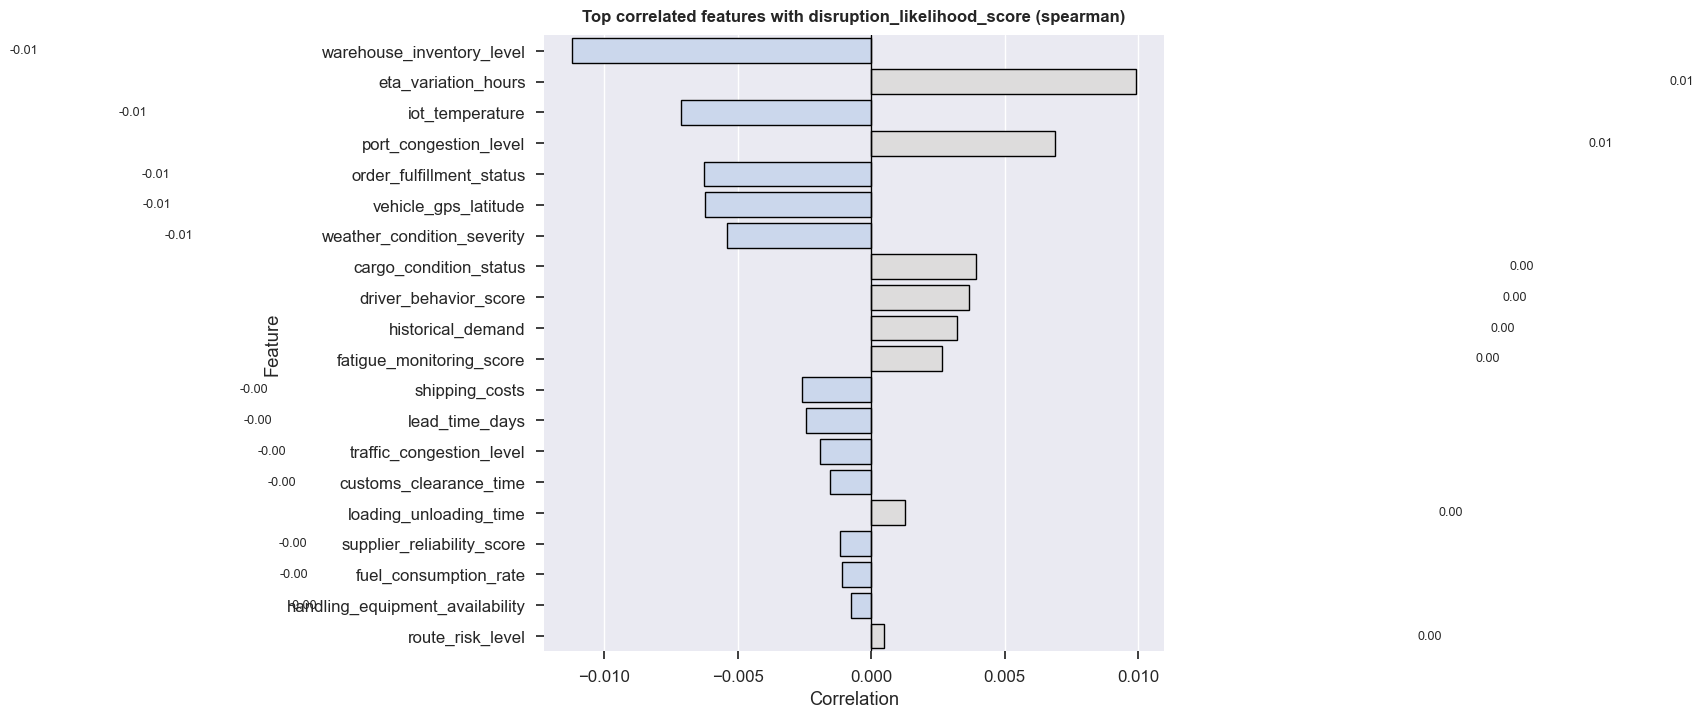

C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


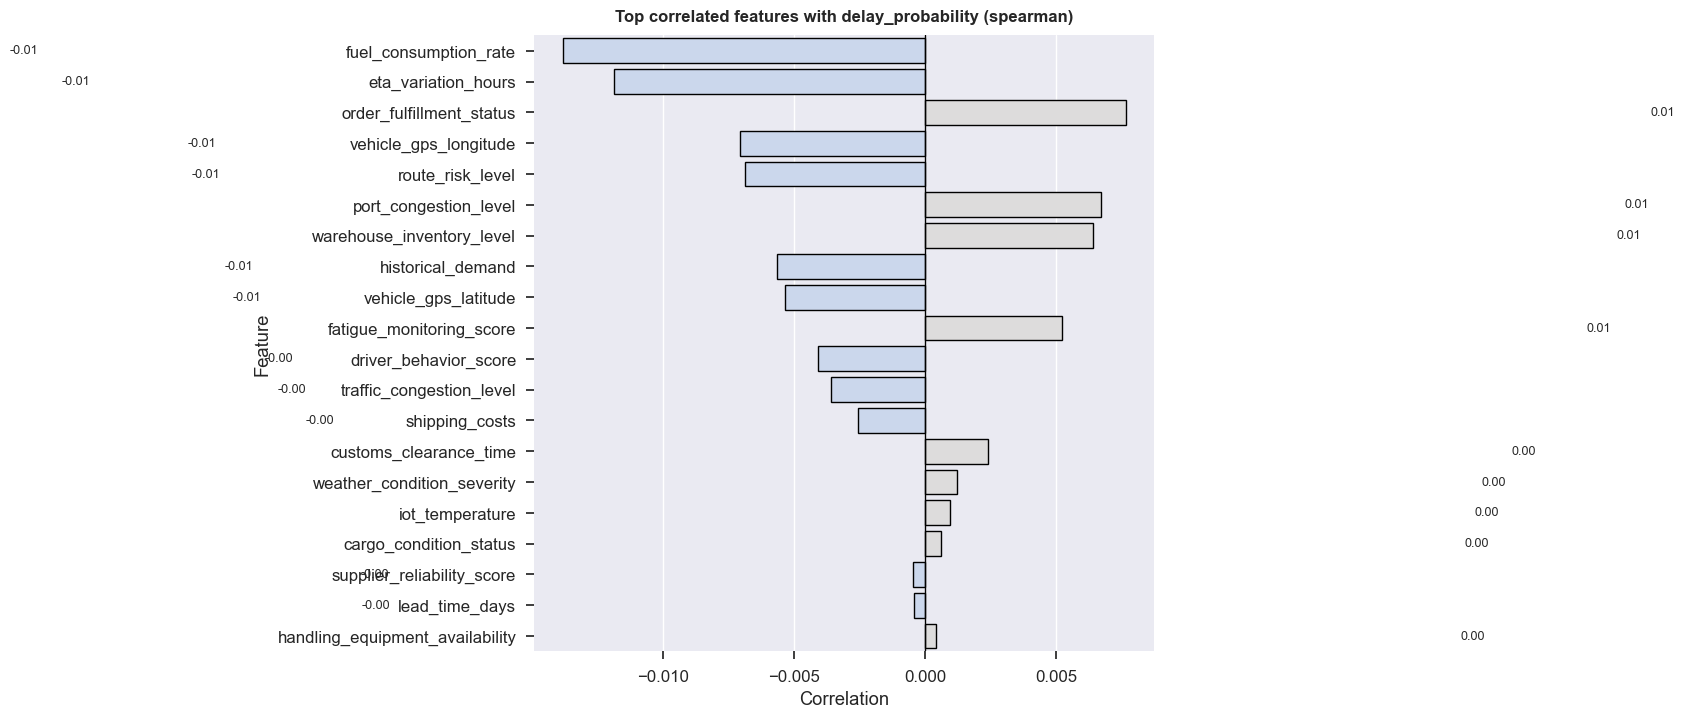

C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


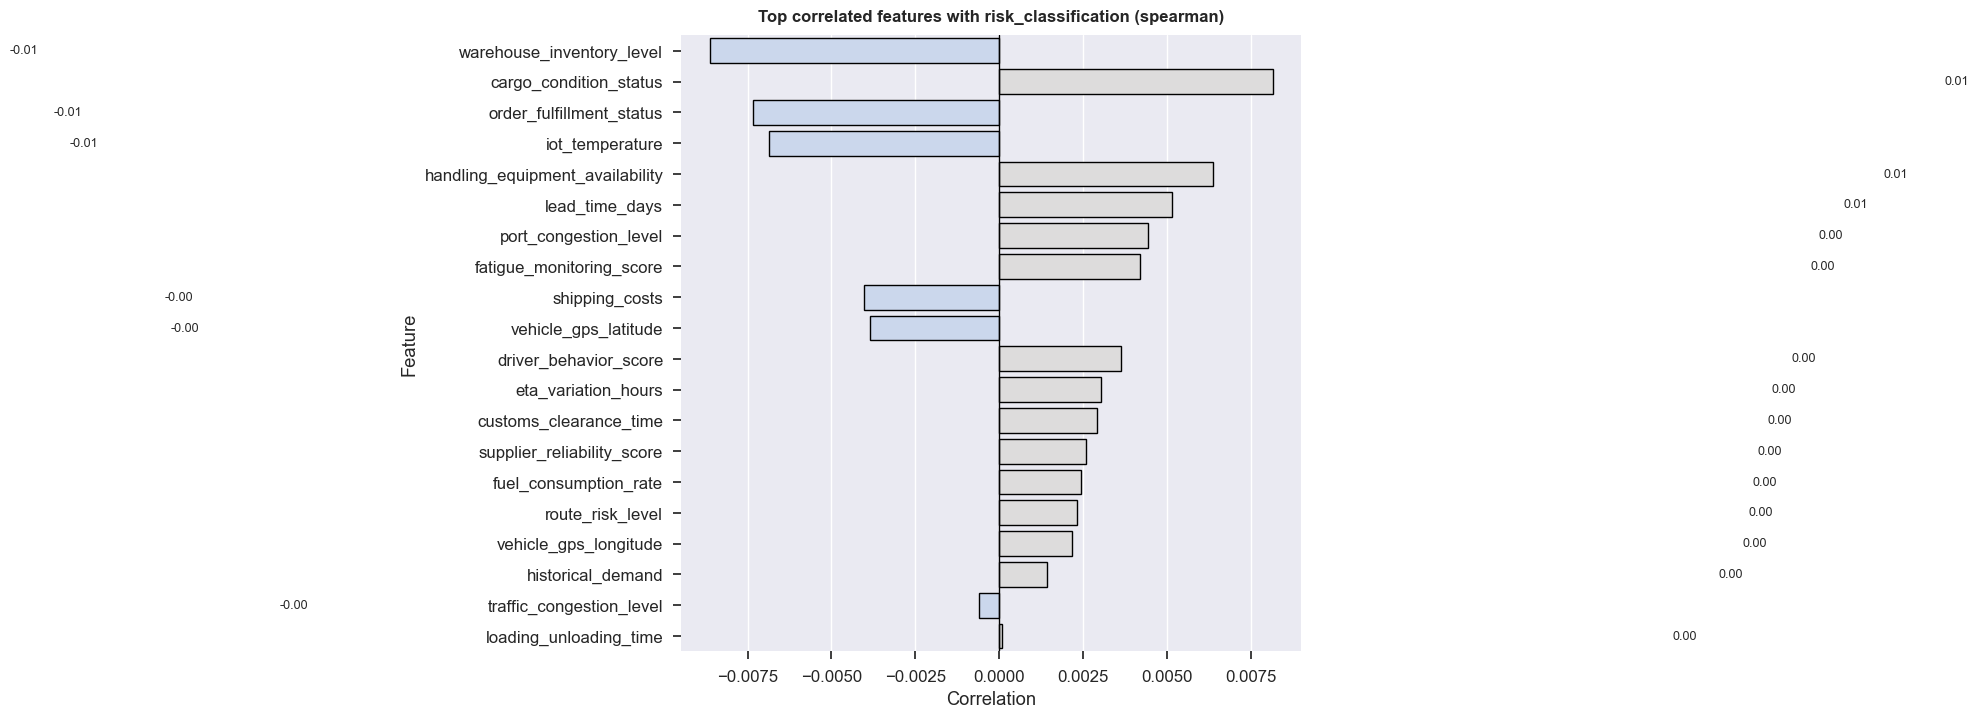

C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\PRANAV\AppData\Local\Temp\ipykernel_15604\1264404845.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


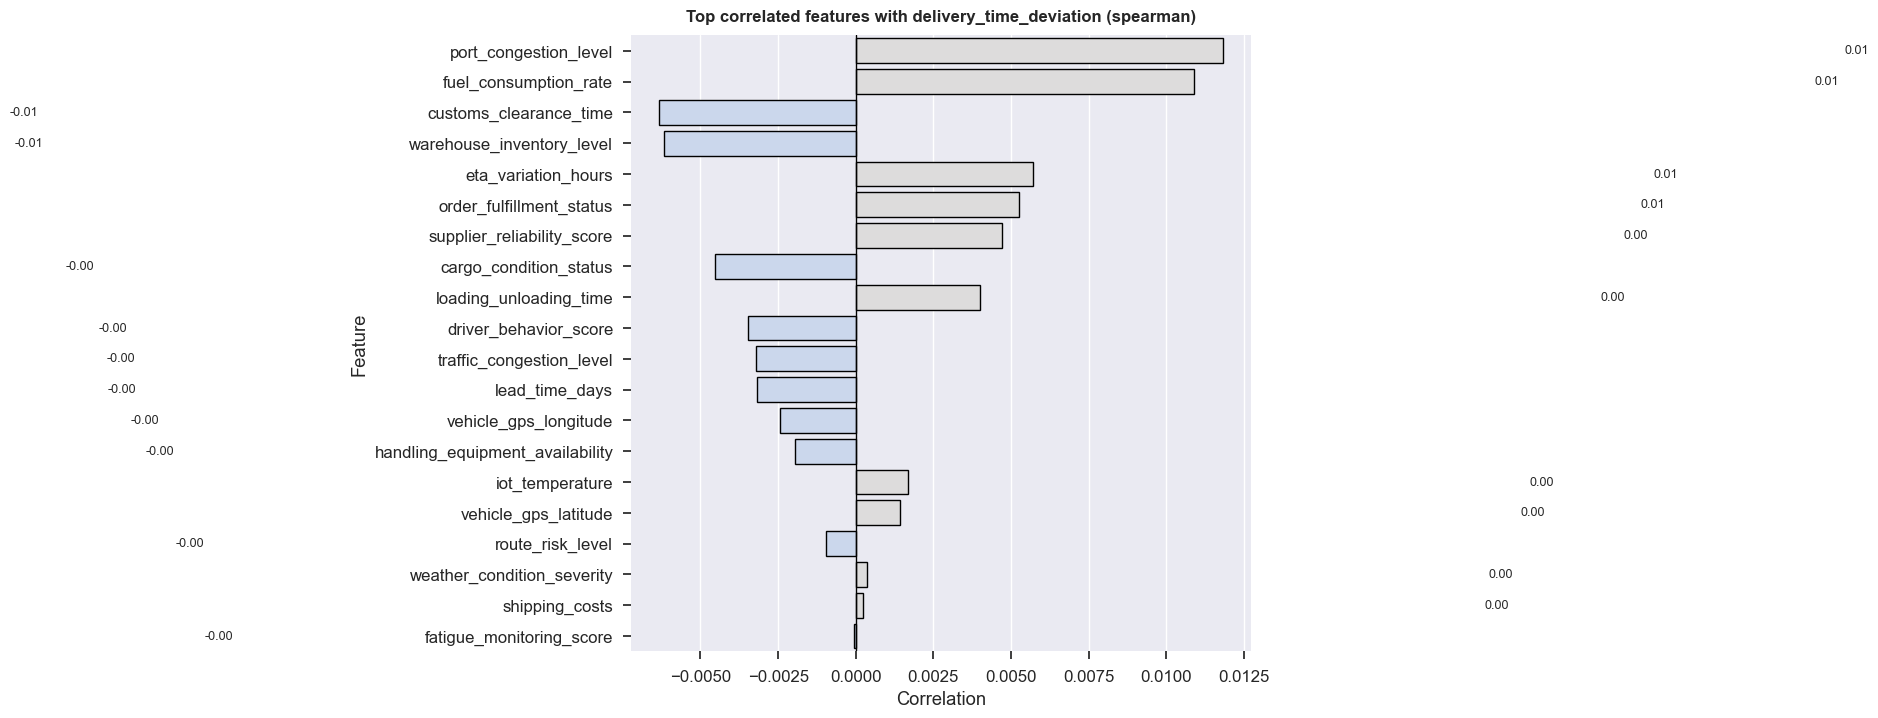

In [45]:
# --- 3) Per-target Top-20 correlated features ---
# For each target, show a bar chart of top-20 correlations (by absolute value)
for target in target_variables:
    series = corr_t_vs_f.loc[target]
    title = f"Top correlated features with {target} ({correlation_method})"
    file_path = os.path.join(output_dir, f"top20_{target}_{correlation_method}.png")
    plot_top_k_bars(series, k=min(20, len(series)), title=title, figsize=(8, 8), save_path=file_path)
